In [55]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import normal
import math
import usefulFunctions
from random import randrange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
control = {}
sick = {}
male = {}
female = {}
age = []
months = []

fileName = "Master_PL.xlsx - Master_PL.csv"
table = pd.read_csv(fileName, header=0, 
                    names=["id", "type", "gender", "age", "monthsFromScreening", "protein_BL", "protein_V4",
                          "protein_V6", "protein_V8", "protein_V10", "protein_V12"])

totalRows = len(table.values)

# splitting data into female vs male, control vs sick, plus storing the age and months data
# into arrays so we can look at their distributions later (to understand good age bands)
for row in table.to_dict(orient='records'):
    if row['type'] is not None:
        if row['type'] == 1:
            control[int(row['id'])] = row
        else:
            sick[int(row['id'])] = row
    
    if row['gender'] is not None:
        if row['gender'] == 1:
            female[int(row['id'])] = row
        else:
            male[int(row['id'])] = row

    
    if row['age'] is not None:
        age.append(row['age'])
    
    if row['monthsFromScreening'] is not None:
        months.append(row['monthsFromScreening'])

print "Number of data points that are males : " + str(len(male))
print "Number of data points that are females : " + str(len(female))
print "Number of data points that are control : " + str(len(control))
print "Number of data points that are sick : " + str(len(sick))

Number of data points that are males : 403
Number of data points that are females : 216
Number of data points that are control : 196
Number of data points that are sick : 423


In [3]:
tup = usefulFunctions.combine(male, female, control, sick)
maleSplit = tup[0]
femaleSplit = tup[1]
print "Number of Males that are in the Control : " + str(len(maleSplit[0]))
print "Number of Males that are Sick : " + str(len(maleSplit[1]))
print "Number of Females that are in the Control : " + str(len(femaleSplit[0]))
print "Number of Females that are Sick : " + str(len(femaleSplit[1]))

Number of Males that are in the Control : 126
Number of Males that are Sick : 277
Number of Females that are in the Control : 70
Number of Females that are Sick : 146


In [88]:
# getting only fully filled out entries to plot
proteinKeys = ['protein_BL', 'protein_V4', 'protein_V6', 'protein_V8', 'protein_V10', 'protein_V12']
controlMales = []
for key in maleSplit[0]:
    male = maleSplit[0][key]
    valid = True
    for key2 in proteinKeys:
        if not usefulFunctions.checkForValid(male[key2]) or male[key2] >= 100 or male[key2] <= 10:
            valid = False
    
    if valid:
        temp = []
        for key2 in proteinKeys:
            temp.append(male[key2])
        
        controlMales.append(temp)

sickMales = []
for key in maleSplit[1]:
    male = maleSplit[1][key]
    valid = True
    for key2 in proteinKeys:
        if not usefulFunctions.checkForValid(male[key2]) or male[key2] >= 100 or male[key2] <= 10:
            valid = False
    
    if valid:
        temp = []
        for key2 in proteinKeys:
            temp.append(male[key2])
        
        sickMales.append(temp)

controlFemales = []
for key in femaleSplit[0]:
    female = femaleSplit[0][key]
    valid = True
    for key2 in proteinKeys:
        if not usefulFunctions.checkForValid(female[key2]) or female[key2] >= 100 or female[key2] <= 10:
            valid = False
    
    if valid:
        temp = []
        for key2 in proteinKeys:
            temp.append(female[key2])
        
        controlFemales.append(temp)

sickFemales = []
for key in femaleSplit[1]:
    female = femaleSplit[1][key]
    valid = True
    for key2 in proteinKeys:
        if not usefulFunctions.checkForValid(female[key2]) or female[key2] >= 100 or female[key2] <= 10:
            valid = False
    
    if valid:
        temp = []
        for key2 in proteinKeys:
            temp.append(female[key2])
        
        sickFemales.append(temp)


In [89]:
len(controlMales), len(controlFemales)

(18, 13)

In [90]:
len(sickMales), len(sickFemales)

(33, 11)

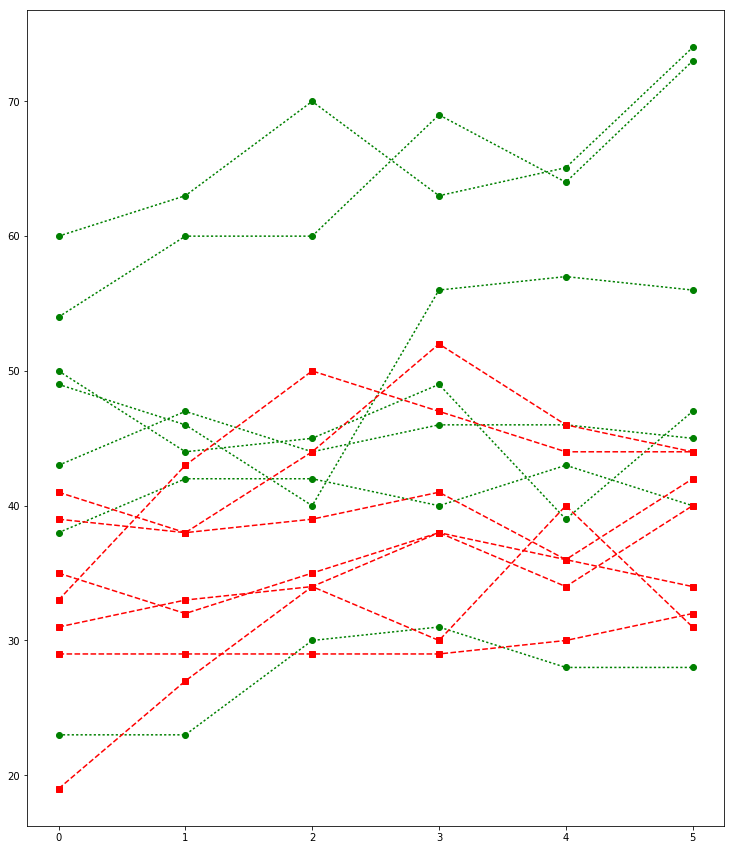

In [91]:
randomControlMales = []
randomSickMales = []

size = len(controlMales)
for i in range(7):
    index = randrange(0, size)
    randomControlMales.append(controlMales[index])
    temp = controlMales[index]
    controlMales[index] =  controlMales[size-1]
    controlMales[size-1] = temp
    size +=-1

size = len(sickMales)
for i in range(7):
    index = randrange(0, size)
    randomSickMales.append(sickMales[index])
    temp = sickMales[index]
    sickMales[index] = sickMales[size-1]
    sickMales[size-1] = temp
    size +=-1

labels = []
for entry in randomControlMales:
    labels.append(0)
for entry in randomSickMales:
    labels.append(1)

allFullyFilledMales = randomControlMales + randomSickMales
colors = ['go:', 'rs--']

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledMales, labels, colors)
# green is control
# red is sick

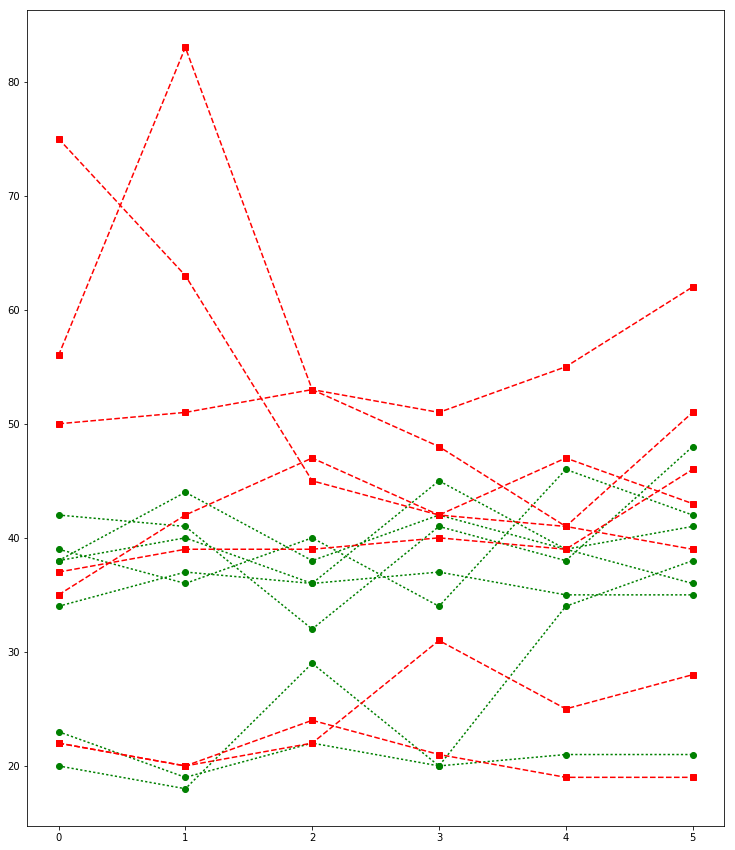

In [86]:
randomControlFemales = []
randomSickFemales = []

size = len(controlFemales)
for i in range(7):
    index = randrange(0, size)
    randomControlFemales.append(controlFemales[index])
    temp = controlFemales[index]
    controlFemales[index] =  controlFemales[size-1]
    controlFemales[size-1] = temp
    size +=-1

size = len(sickFemales)
for i in range(7):
    index = randrange(0, size)
    randomSickFemales.append(sickFemales[index])
    temp = sickFemales[index]
    sickFemales[index] = sickFemales[size-1]
    sickFemales[size-1] = temp
    size +=-1

labels = []
for entry in randomControlFemales:
    labels.append(0)
for entry in randomSickFemales:
    labels.append(1)

allFullyFilledFemales = randomControlFemales + randomSickFemales
colors = ['go:', 'rs--']

usefulFunctions.createLinePlotsOnSamePlot(allFullyFilledFemales, labels, colors)